In [1]:
import numpy as np
import pyproj
import glob
import datetime
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
np.float = float

In [2]:
figpath = '/Users/carmennab/Dropbox/michel_csao/'

### load grid

In [3]:
def WGS84toEASE2(lon, lat):
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x , y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

file='/Users/carmennab/cpom_server//home/gch/SS_budget_23/grids_S/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)
lon = npzfile["lons"]
lat = npzfile["lats"]
grid_x, grid_y = WGS84toEASE2(lon, lat)

In [4]:
datapath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/2024-08-15/data_out_smoothed/'
files = sorted(glob.glob(datapath+'*.nc'))

In [5]:
all_budgets = [] 

for file in files:
    start_date_str = file.split('/')[9].split('_')[1].split('--')[0]
    start_date = datetime.datetime.strptime(start_date_str,"%Y%m%d").date()

    if start_date.month in [10,11,12,1,2,3]:
        data = Dataset(file)

        thickness = np.array(data['thickness']) 

        b = {'year':start_date.year,'month':start_date.month,'thickness':thickness}

        all_budgets.append(b)
    
### create dataframe of all budgets
all_budgets = pd.DataFrame(all_budgets).sort_values(['month','year'])

In [6]:
climatology = np.nanmean(np.array([data for data in all_budgets['thickness']]),axis=0)

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_2942/3312029298.py:1: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(np.array([data for data in all_budgets['thickness']]),axis=0)


### plot climatology and yearly anomaly from climatology

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_2942/4292305497.py:15: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.array([data for data in year_data['thickness']]),axis=0)


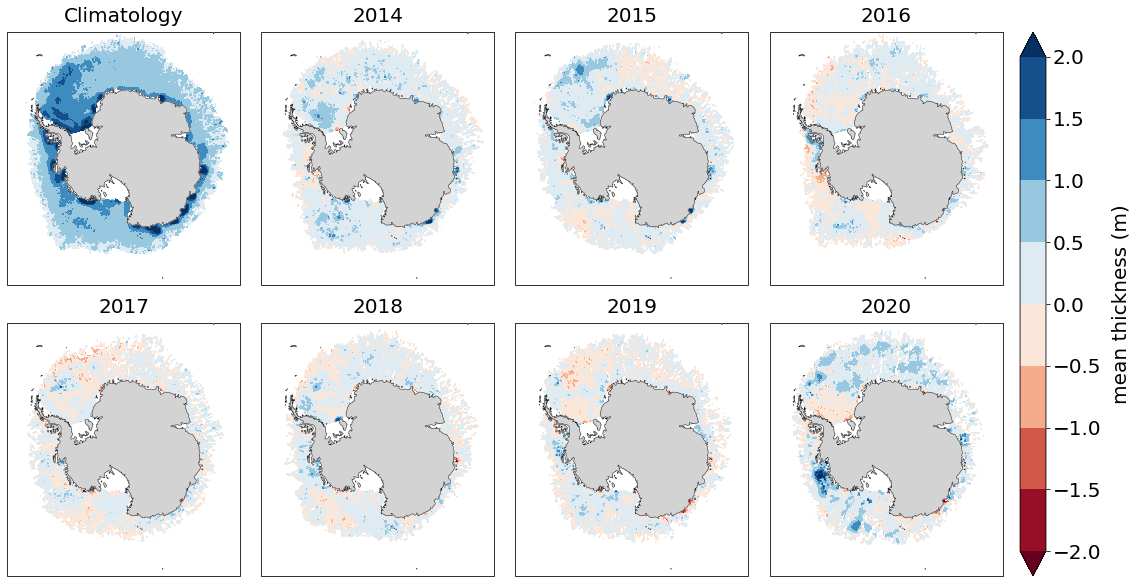

In [7]:
fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=4, nrows=2, wspace=0.05,hspace=0.15)

ax = fig.add_subplot(spec[0],projection=ccrs.SouthPolarStereo())
ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
cmap = ax.contourf(grid_x,grid_y,climatology,cmap='RdBu',levels=np.arange(-2,2.5,0.5),extend='both')
ax.set_title('Climatology',fontsize=20,pad=10) 

count = 1
for count_y,year in enumerate(sorted(set(all_budgets['year']))):
    year_data = all_budgets[all_budgets['year']==year]

    mean = np.nanmean(np.array([data for data in year_data['thickness']]),axis=0)
    diff = mean - climatology
    ax = fig.add_subplot(spec[count],projection=ccrs.SouthPolarStereo())
    ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
    ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
    cmap = ax.contourf(grid_x,grid_y,diff,cmap='RdBu',levels=np.arange(-2,2.5,0.5),extend='both')

    if count == 7: 
        cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.755]) # x, y, width, height
        a = fig.colorbar(cmap, cax=cbar_ax) 
        a.set_label('mean thickness (m)',size=20,labelpad=10)
        a.ax.tick_params(labelsize=20)
    count += 1 
    ax.set_title(year,fontsize=20,pad=10)
plt.savefig(f'{figpath}sit_summer.jpg',bbox_inches = "tight", dpi = 400)